In [6]:
from pathlib import Path

import pandas as pd
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

In [7]:
from bioemu import observables_ddr as observables

In [8]:
def read_dir(output_dir):
    samples_files = sorted(list(output_dir.glob("batch_*.npz")))
    data = [np.load(f) for f in samples_files]
    sequences = [d["sequence"].item() for d in data]
    if len(set(sequences)) != 1:
        raise ValueError(f"Expected all sequences to be {sequences[0]}, but got {set(sequences)}")
    positions = torch.tensor(np.concatenate([d["pos"] for d in data]))
    node_orientations = torch.tensor(
        np.concatenate([d["node_orientations"] for d in data])
    )

    return sequences[0], positions, node_orientations

# Quick check of wild type protein

In [9]:
_, wt_pos, wt_orientations = read_dir(Path('../../bioemu-testing/protein_results/psd95_pdz3/test0/I4V/'))

In [10]:
h = observables.compute_h_for_grb2_sh3(wt_pos, wt_orientations, "structures/1be9_trimmed.pdb")

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        , 1.10000002, 1.20000005, 1.29999995, 1.39999998,
        1.5       ]),
 <BarContainer object of 10 artists>)

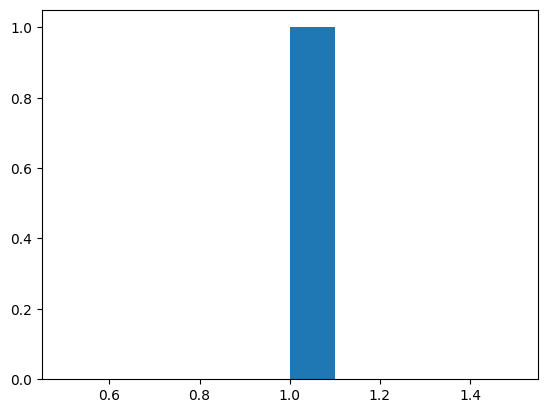

In [11]:
plt.hist(h[:, 0])

# Plot non-ft BioEmu results for many mutants

In [12]:
records = []

for mutation_dir in sorted(Path('../../bioemu-testing/protein_results/psd95_pdz3/test0/').glob('*')):
    mutation_name = mutation_dir.name
    print(mutation_name)

    _, pos, orientations = read_dir(mutation_dir)
    h = observables.compute_h_for_psd95_pdz3(pos, orientations, "structures/1be9_trimmed.pdb")

    # rough proxy for dg_binding
    h_folded, h_bindable = h[:, 0], h[:, 1]
    dg_folding = -np.log((h_folded == 1).sum() / (h_folded == 0).sum()).item()
    dg_binding = -np.log((h_bindable == 1).sum() / (h_bindable == 0).sum()).item()

    print(h_folded.shape[0])

    if h_folded.shape[0] == 1:
        # skip stubs without sufficient samples
        continue

    # bootstrapping for error estimates
    bootstrap_dg_f = [-np.log((np.random.choice(h_folded, len(h_folded)) == 1).sum() / (np.random.choice(h_folded, len(h_folded)) == 0).sum()) for _ in range(1000)]
    bootstrap_dg_b = [-np.log((np.random.choice(h_bindable, len(h_bindable)) == 1).sum() / (np.random.choice(h_bindable, len(h_bindable)) == 0).sum()) for _ in range(1000)]

    dg_folding_err, dg_binding_err = np.std(bootstrap_dg_f), np.std(bootstrap_dg_b)
    
    records.append((mutation_name, dg_folding, dg_binding, dg_folding_err, dg_binding_err))

A33C
1
A33P
1
A33W
500
A37E


/tmp/ipykernel_217310/1982217326.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  bootstrap_dg_f = [-np.log((np.random.choice(h_folded, len(h_folded)) == 1).sum() / (np.random.choice(h_folded, len(h_folded)) == 0).sum()) for _ in range(1000)]
/scratch/users/ddrichma/micromamba/envs/mamba250530-bioemu-ft/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


500
A37G
500
A37V
500
A60C
1
A60F
500
A60G
500
A60N
1
A60R
500
A60W
1
A65W
1
A66E
1
A66F
500
A66I
500
A66S
1
A66V
500
A68F
1
A68H
500
A68K
1
A68Q
500
A68R
500
A68V
1
A72G
500
A72N
1
A80C
1
A80D
1
A80F
1
A80P
1
D22E
500
D22F
1
D22I
500
D22R
1
D38L
1
D38R


/tmp/ipykernel_217310/1982217326.py:13: RuntimeWarning: divide by zero encountered in log
  dg_binding = -np.log((h_bindable == 1).sum() / (h_bindable == 0).sum()).item()


500
D38T
500
D38W
500
D38Y
1
D47A
1
D47H
500
D47M
500
D56A
500
D56I
1
E21A
1
E21M
1
E21R
500
E21S
1
E21T
1
E21V
500
E24I
1
E24R
500
E24W
1
E42G
500
E42H
1
E42K
500
E42L
500
E42W
1
E63A
1
E63D
1
E63F
500
E63G
1
E63I
1
E63N
500
E63S
1
E63T
1
E63W
1
F15I
1
F15T
1
F27L
500
F27R
1
F27S
1
F30D
1
F30L
1
F30M
1
F30R
1
F30S
1
F30W
1
G12I
1
G12N
1
G12V
1
G19P
1
G19R
500
G19T


/tmp/ipykernel_217310/1982217326.py:23: RuntimeWarning: divide by zero encountered in log
  bootstrap_dg_b = [-np.log((np.random.choice(h_bindable, len(h_bindable)) == 1).sum() / (np.random.choice(h_bindable, len(h_bindable)) == 0).sum()) for _ in range(1000)]


1
G20C
1
G20D
1
G20R
1
G23A
1
G23P
1
G23Q
500
G25R
500
G34A
500
G34C
500
G34D
500
G34F
500
G34R
1
G35A
1
G35M
1
G35Q
500
G35S
1
G41D
500
G41K
1
G41L
500
G41M
500
G41P
1
G46D
1
G46H
1
G46K
1
G46N
500
G46P
500
G46W
1
G54M
1
G54Q
500
G54R
500
G54S
500
G73M
1
G73R
1
G73S
1
G73T
1
G73V
1
G9E
1
G9P
500
G9R
1
H62F
1
H62W
1
H7C
500
H7F
500
H7K
1
H7L
1
H7M
1
H7P
500
H7Q
1
H7S
500
I26A
1
I26P
500
I26T
1
I26V
500
I28V
1
I31L
500
I49L
1
I49M
1
I49P
500
I49T
1000
I4A
1
I4C
500
I4F
1
I4R
500
I4V
1
I67A
1
I67F
500
I67K
1
I67R
1
I67T
500
I67W
500
I6A
1
I6C
1
I78T
1
I78V
1
I79E
1
I79G
500
I79K
1
I79Q
500
I79T
1
K45I
1
K45Y
1
K70G
1
K70H
1
K70L
1
K83A
1
K83D
1
K83G
500
K83I
500
K83N
1
L13I
500
L13W
500
L32Q
500
L32R
500
L32S
500
L32T
1
L39A
1
L39D
1
L39T
1
L39Y
500
L43F
1
L50A
500
L50C
500
L50I
500
L50R
500
L50T
1
L50Y
500
L57Y
500
L69C
1
L69I
1
L69M
1
N16A
1
N16H
1
N53C
1
N53Q
1
N53R
1
N53T
500
N59A
1
N59K
1
N59M
1
N59W
1
N71A
500
N71C
500
N71Q
1
N71R
1
N71S
1
P1N
1
P1Q
1
P1T
500
P1V
500
P1W
1
P36C
1
P

In [13]:
h[:,0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

<Axes: ylabel='Count'>

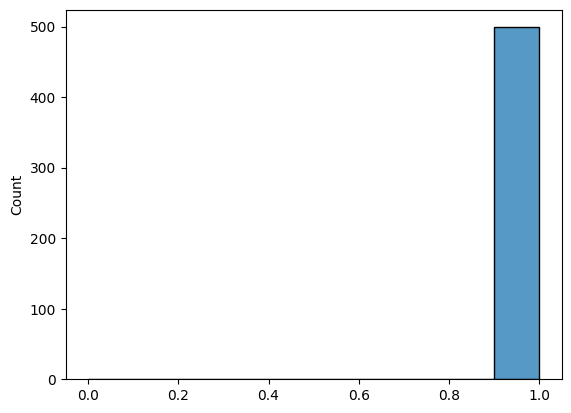

In [14]:
sns.histplot(h[:,0])

In [15]:
records

[('A33W', -6.212605953216553, 0.9744218587875366, nan, 0.07616356569455518),
 ('A37E', -4.410776138305664, 2.030866861343384, nan, 0.12979098667648462),
 ('A37G', -5.109977722167969, 1.1093076467514038, nan, 0.08458743721369538),
 ('A37V', -5.517452716827393, 1.1636759042739868, nan, 0.08152360714258235),
 ('A60F', -6.212605953216553, 0.9148911237716675, nan, 0.07762270822950662),
 ('A60G', -6.212605953216553, 1.0150127410888672, nan, 0.07712515130674794),
 ('A60R', -inf, 1.1200608015060425, nan, 0.08405352563915468),
 ('A66F', -6.212605953216553, 1.0668636560440063, nan, 0.08430018961371324),
 ('A66I', -6.212605953216553, 1.2656663656234741, nan, 0.08524873252810235),
 ('A66V', -inf, 1.1747359037399292, nan, 0.08386816973793446),
 ('A68H', -6.212605953216553, 0.9345625042915344, nan, 0.07685897606774321),
 ('A68Q', -6.212605953216553, 0.8188868761062622, nan, 0.07394824883542804),
 ('A68R', -6.212605953216553, 0.9051175117492676, nan, 0.07753423510549412),
 ('A72G', -6.212605953216553

In [16]:
bioemu_non_ft_predictions = pd.DataFrame.from_records(records, columns=['id', 'dg_folding_est', 'dg_binding_est', 'dg_folding_err', 'dg_binding_err'])

# Adjust to ddgs. What we're estimating here is really something like a dg from "bindable" to nonbindable
# which can be viewed as a ddg of binding
#wt_est = bioemu_non_ft_predictions.loc[bioemu_non_ft_predictions['id'] == 'wt', 'dg_binding_est'].item()
#bioemu_non_ft_predictions['ddg_binding_est'] -= wt_est
# for purposes of h* it's easier just to stick with dg

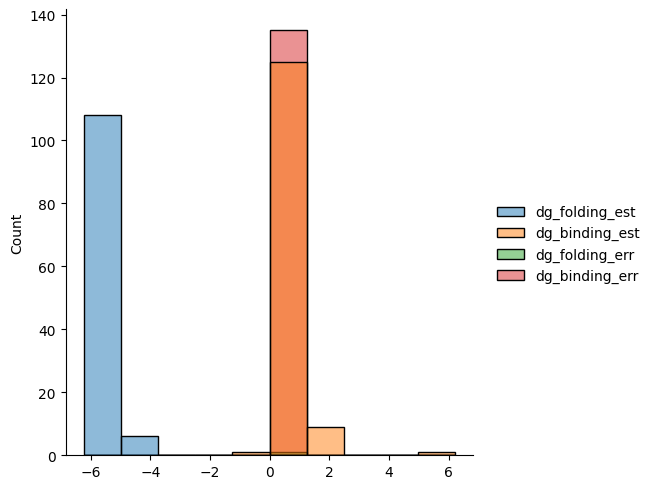

In [17]:
sns.displot(bioemu_non_ft_predictions)

# Compare to ground truth

In [18]:
gt_data = pd.read_csv('reference_h/PSD95_PDZ3_high_confidence.csv')
gt_data.loc[gt_data.id == '-0-', 'id'] = 'wt' # rename wt row

In [19]:
combined_df = gt_data.merge(bioemu_non_ft_predictions, on='id')

In [20]:
combined_df.columns

Index(['Pos_ref', 'id', 'id_ref', 'Pos', 'mut_order', 'f_dg_pred',
       'f_ddg_pred', 'f_ddg_pred_sd', 'b_dg_pred', 'b_ddg_pred',
       'b_ddg_pred_sd', 'f_ddg_pred_conf', 'b_ddg_pred_conf', 'HAmin_ligand',
       'scHAmin_ligand', 'RSASA', 'SS', 'Pos_class', 'protein', 'WT_AA', 'Mut',
       'b_ddg_wposmeanabs', 'b_ddg_wposse', 'allosteric', 'orthosteric',
       'allosteric_mutation', 'seq', 'prob_folded', 'prob_bound',
       'dg_folding_est', 'dg_binding_est', 'dg_folding_err', 'dg_binding_err'],
      dtype='object')

In [21]:
combined_df.loc[combined_df.id=='wt']

,Pos_ref,id,id_ref,Pos,mut_order,f_dg_pred,f_ddg_pred,f_ddg_pred_sd,b_dg_pred,b_ddg_pred,...,allosteric,orthosteric,allosteric_mutation,seq,prob_folded,prob_bound,dg_folding_est,dg_binding_est,dg_folding_err,dg_binding_err
111,NaN,wt,-0-,NaN,0,-1.309381,0.0,0.0,-0.706656,0.0,...,NaN,NaN,NaN,PRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKG...,0.78741,0.669662,-6.212606,0.954404,NaN,0.076695


/scratch/users/ddrichma/micromamba/envs/mamba250530-bioemu-ft/lib/python3.12/site-packages/scipy/stats/_stats_py.py:4624: RuntimeWarning: invalid value encountered in subtract
  ym = y - ymean


Text(0.5, 9.444444444444438, 'Estimated $\\Delta G_{fold}$ from BioEmu')

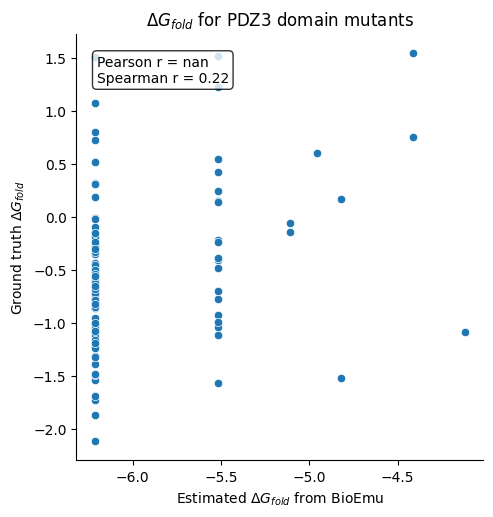

In [27]:
g = sns.relplot(combined_df, y='f_dg_pred', x='dg_folding_est')
#g.ax.errorbar(combined_df['dg_folding_est'], combined_df['f_dg_pred'], xerr=combined_df['dg_folding_err'], fmt='none', alpha=0.5)
pearson_r = scipy.stats.pearsonr(combined_df['f_dg_pred'], combined_df['dg_folding_est'])[0]
spearman_r = scipy.stats.spearmanr(combined_df['f_dg_pred'], combined_df['dg_folding_est'])[0]
g.ax.text(0.05, 0.95, f'Pearson r = {pearson_r:.2f}\nSpearman r = {spearman_r:.2f}', transform=g.ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title(r'$\Delta G_{fold}$ for PDZ3 domain mutants')
plt.ylabel(r'Ground truth $\Delta G_{fold}$')
plt.xlabel(r'Estimated $\Delta G_{fold}$ from BioEmu')

In [23]:
scipy.stats.spearmanr(combined_df.f_dg_pred, combined_df.dg_folding_est)

SignificanceResult(statistic=0.22286047358887498, pvalue=0.00911071285264484)

Text(0.5, 1.0, 'binding ddg change')

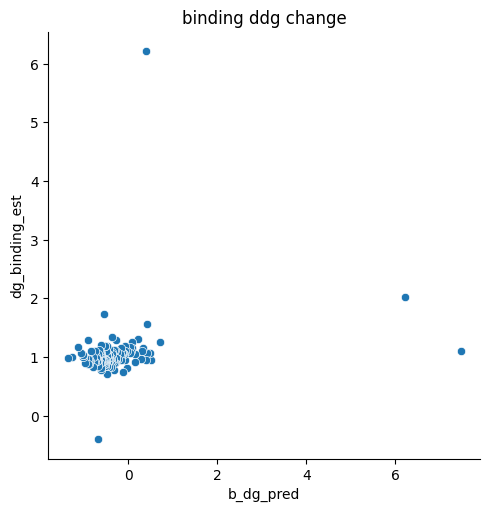

In [24]:
sns.relplot(combined_df, x='b_dg_pred', y='dg_binding_est')
plt.title('binding ddg change')

In [25]:
scipy.stats.spearmanr(combined_df.b_ddg_pred, combined_df.dg_binding_est)

SignificanceResult(statistic=0.2831272883575115, pvalue=0.0008379702709801244)

# test h_star code

In [26]:
observables.h_star_for_grb2_sh3('reference_h/GRB2_SH3_high_confidence.csv')

(0      TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTHM...
 1      TYVQALFDCDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 2      TYVQALFDVDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 3      TYVQALIDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 4      TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNRWKGACHGQTGM...
                              ...                        
 584    TYVQALFCFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 585    TYVQALFDFDPQEDGELGFRRGYFIHVMDNSDPNWWKGACHGQTGM...
 586    TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 587    TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWDGACHGQTGM...
 588    TYVNALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 Name: seq, Length: 589, dtype: object,
 tensor([[0.1976, 0.0045],
         [0.5153, 0.1624],
         [0.5799, 0.1986],
         ...,
         [0.7065, 0.9182],
         [0.2275, 0.9187],
         [0.2778, 0.9362]]))